# Train the model

In [1]:
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import load_model
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../functions')
from ipynb.fs.full.models import regression


Using TensorFlow backend.


trial information:
- pure signals, without noise
- uniformly scaled
- mass sampled with respect to chirp mass and eta

# Load data

In [3]:
# load main regression data 
f_path = 'r_data_2A.h5'
X1 = pd.read_hdf(f_path, 'X')
y1 = pd.read_hdf(f_path, 'y')

# load main regression data 
f_path = '..\classification\c_data_1B.h5'
X2 = pd.read_hdf(f_path, 'reg_X')
y2 = pd.read_hdf(f_path, 'reg_y')
y2 = pd.DataFrame(np.sort(y2.values, axis=1), y2.index, y2.columns)

# Concat
X = pd.concat([X1, X2],axis=0,ignore_index=True)
y = pd.concat([y1, y2],axis=0,ignore_index=True)

In [7]:
# Data preprocessing

# uniformly scale data
X_scaled=X*(10**22)

# Train test split with sklearn
X_train,X_test,y_train,y_test = train_test_split(X_scaled.values,y.values,test_size=0.1,random_state=13)

# save test set
f_path = 'r_testdata_2A.h5'
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
X_test_df.to_hdf(f_path, key='X', mode='w')
y_test_df.to_hdf(f_path, key='y')

C:\Users\Ruining\.conda\envs\machine_learning\lib\site-packages\pandas\core\generic.py:2531: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block0_values] [items->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167

In [8]:
# Reshape data
Xtrain = []
for i in np.arange(len(X_train)):
    h = X_train[i].reshape(4096,1)
    Xtrain.append(h)
X_train = np.asarray(Xtrain)

Xtest = []
for i in np.arange(len(X_test)):
    h = X_test[i].reshape(4096,1)
    Xtest.append(h)
X_test = np.asarray(Xtest)

# Train

In [9]:
# Check model performance accuracy before
model = load_model("regression1B.h5")

# Pre_train score record
pre_score = model.evaluate(X_test, y_test, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


1444/1444 [==============================] - 3s 2ms/step


In [10]:
print(pre_score)

[0.913244813432984, 1.729042062468806, 0.913244813432984]


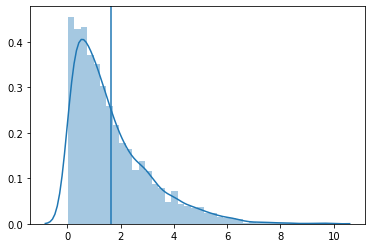

Mean %difference: 1.6377839516959358
Standard deviation of %difference: 1.4375127546312874


In [11]:
# predict before training
preds_bf = model.predict(X_test)
 
# compute the difference between the *predicted* and *actual* 
# then compute the percentage difference and the absolute percentage difference
diff_bf = preds_bf.flatten() - y_test.flatten()
percentDiff_bf = (diff_bf / y_test.flatten()) * 100
absPercentDiff_bf = np.abs(percentDiff_bf)
 
# compute the mean and standard deviation of the absolute percentage
# difference
mean_bf = np.mean(absPercentDiff_bf)
std_bf = np.std(absPercentDiff_bf)

sns.distplot(absPercentDiff_bf)
plt.axvline(mean_bf, 0,1)
plt.show()

print("Mean %difference:",mean_bf)
print("Standard deviation of %difference:",std_bf)

In [12]:
epoch = 200
batch_size = 5

earlystopping_callback = EarlyStopping(monitor='mean_squared_error',verbose=1,min_delta=0.5,patience=30,baseline=None)

history = model.fit(X_train, y_train, validation_split = 0.20, batch_size=batch_size, epochs=epoch, verbose=1,
                   callbacks=[earlystopping_callback])

Train on 10391 samples, validate on 2598 samples
Epoch 1/200
10391/10391 [==============================] - 20s 2ms/step - loss: 0.8852 - mean_squared_error: 1.7173 - mean_absolute_error: 0.8852 - val_loss: 1.2503 - val_mean_squared_error: 2.9984 - val_mean_absolute_error: 1.2503
Epoch 2/200
10391/10391 [==============================] - 20s 2ms/step - loss: 0.8363 - mean_squared_error: 1.5242 - mean_absolute_error: 0.8363 - val_loss: 0.8352 - val_mean_squared_error: 1.4752 - val_mean_absolute_error: 0.8352
Epoch 3/200
10391/10391 [==============================] - 20s 2ms/step - loss: 0.7803 - mean_squared_error: 1.3077 - mean_absolute_error: 0.7803 - val_loss: 0.8708 - val_mean_squared_error: 1.7613 - val_mean_absolute_error: 0.8708
Epoch 4/200
10391/10391 [==============================] - 20s 2ms/step - loss: 0.7554 - mean_squared_error: 1.2215 - mean_absolute_error: 0.7554 - val_loss: 0.9004 - val_mean_squared_error: 1.6327 - val_mean_absolute_error: 0.9004
Epoch 5/200
10391/10391

Epoch 36/200
10391/10391 [==============================] - 19s 2ms/step - loss: 0.4937 - mean_squared_error: 0.4859 - mean_absolute_error: 0.4937 - val_loss: 0.6777 - val_mean_squared_error: 1.0568 - val_mean_absolute_error: 0.6777
Epoch 37/200
10391/10391 [==============================] - 19s 2ms/step - loss: 0.5004 - mean_squared_error: 0.5099 - mean_absolute_error: 0.5004 - val_loss: 0.7351 - val_mean_squared_error: 1.2322 - val_mean_absolute_error: 0.7351
Epoch 38/200
10391/10391 [==============================] - 19s 2ms/step - loss: 0.4845 - mean_squared_error: 0.4733 - mean_absolute_error: 0.4845 - val_loss: 0.6792 - val_mean_squared_error: 1.0799 - val_mean_absolute_error: 0.6792
Epoch 39/200
10391/10391 [==============================] - 19s 2ms/step - loss: 0.4955 - mean_squared_error: 0.4966 - mean_absolute_error: 0.4955 - val_loss: 0.7543 - val_mean_squared_error: 1.1683 - val_mean_absolute_error: 0.7543
Epoch 40/200
10391/10391 [==============================] - 19s 2ms/

# Save

In [15]:
# Save model
model.save('regression2A.h5')  # creates a HDF5 file 'my_model.h5'

In [17]:
import h5py
# save history
h = h5py.File('../history/r_history_2A.h5')
d = history.history
for k, v in d.items():
    h.create_dataset(k, data=np.array(v, dtype=np.float32))

# Training history

In [18]:
# evaluate after training
score = model.evaluate(X_test, y_test, verbose=1)
print(score)

1444/1444 [==============================] - 1s 655us/step
[0.8381733531106542, 1.3911499250628612, 0.8381733531106542]


dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


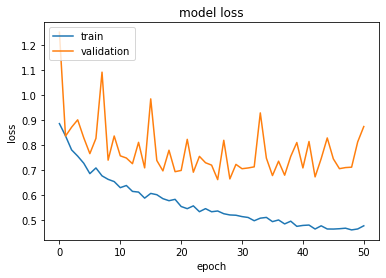

In [19]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Histograms

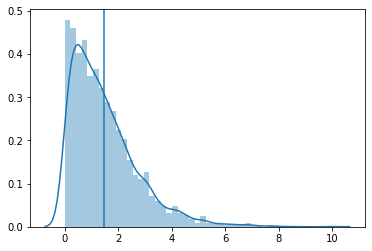

Mean %difference: 1.482126438824447
Standard deviation of %difference: 1.2421048097424086


In [20]:
# histogram for both m1,m2

preds = model.predict(X_test)
 
# compute the difference between the *predicted* and *actual* 
# then compute the percentage difference and the absolute percentage difference
diff = preds.flatten() - y_test.flatten()
percentDiff = (diff / y_test.flatten()) * 100
absPercentDiff = np.abs(percentDiff)
 
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

sns.distplot(absPercentDiff)
plt.axvline(mean, 0,1)
plt.show()

print("Mean %difference:",mean)
print("Standard deviation of %difference:",std)

In [21]:
# Transfer m1,m2 to chirp mass and eta for y_test

M_actual = []
eta_actual = []

for p in y_test:
    m1 = p[0]
    m2 = p[1]
    M = (m1*m2)**(3/5)/(m1+m2)**(1/5)
    M_actual.append(M)
    e = (m1*m2)/(m1+m2)**2
    eta_actual.append(e)

M_actual = np.asarray(M_actual)
eta_actual = np.asarray(eta_actual)   
    
# Transfer m1,m2 to chirp mass and eta for prediction
M_preds = []
eta_preds = []
for p in preds:
    m1 = p[0]
    m2 = p[1]
    M = (m1*m2)**(3/5)/(m1+m2)**(1/5)
    M_preds.append(M)
    e = (m1*m2)/(m1+m2)**2
    eta_preds.append(e)
    
M_preds = np.asarray(M_preds)
eta_preds = np.asarray(eta_preds)

In [22]:
M_diff = M_preds - M_actual
c = (M_diff / M_actual) * 100
print(c)

[-0.45765655 -0.39443534  0.11596209 ... -0.95066537 -0.64920214
 -1.50999435]


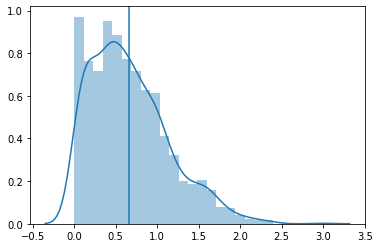

Mean %difference: 0.6647693890120804
Standard deviation of %difference: 0.47277124647763014


In [23]:
# Chirp mass histogram

# compute the difference between the *predicted* and *actual* 
# then compute the percentage difference and the absolute percentage difference
M_diff = M_preds - M_actual
M_percentDiff = (M_diff / M_actual) * 100
M_absPercentDiff = np.abs(M_percentDiff)
 
# compute the mean and standard deviation of the absolute percentage
# difference
M_mean = np.mean(M_absPercentDiff)
M_std = np.std(M_absPercentDiff)

sns.distplot(M_absPercentDiff)
plt.axvline(M_mean, 0,1)
plt.show()

print("Mean %difference:",M_mean)
print("Standard deviation of %difference:",M_std)

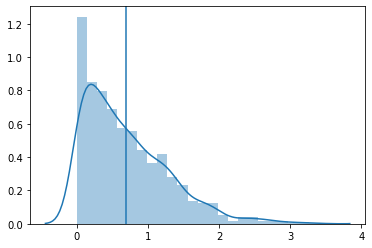

Mean %difference: 0.6962625759339468
Standard deviation of %difference: 0.5901162627230204


In [24]:
# Eta histogram

# compute the difference between the *predicted* and *actual* 
# then compute the percentage difference and the absolute percentage difference
eta_diff = eta_preds - eta_actual
eta_percentDiff = (eta_diff / eta_actual) * 100
eta_absPercentDiff = np.abs(eta_percentDiff)
 
# compute the mean and standard deviation of the absolute percentage
# difference
eta_mean = np.mean(eta_absPercentDiff)
eta_std = np.std(eta_absPercentDiff)

sns.distplot(eta_absPercentDiff)
plt.axvline(eta_mean, 0,1)
plt.show()

print("Mean %difference:",eta_mean)
print("Standard deviation of %difference:",eta_std)

# Select cases that have a larger percentage difference in chirp mass 

In [25]:
count = 0
percentage_cut = 2

percent = []
badmass = []

for i in np.arange(len(M_absPercentDiff)):
    if M_absPercentDiff[i] > percentage_cut:
        count += 1
        badmass.append(y_test[i])
        percent.append(M_absPercentDiff[i])
        print()
        print("Absolute Percent Difference for chirp mass: ",M_absPercentDiff[i])
        print("Actual masses: ",y_test[i])
        print("Predicted masses: ",preds[i])

print()
print("A total number of ", count, " predictions have above ", percentage_cut, " absolute percent difference.")


Absolute Percent Difference for chirp mass:  2.388019366245694
Actual masses:  [45.45589737 54.40306531]
Predicted masses:  [44.960876 52.38313 ]

Absolute Percent Difference for chirp mass:  2.0761288936520366
Actual masses:  [86.04772657 93.21704086]
Predicted masses:  [84.4823  91.03919]

Absolute Percent Difference for chirp mass:  2.3579621538109308
Actual masses:  [69.41095457 88.08062192]
Predicted masses:  [71.5474  89.49823]

Absolute Percent Difference for chirp mass:  2.168852044218616
Actual masses:  [32.18742353 56.63874792]
Predicted masses:  [31.50871  55.372284]

Absolute Percent Difference for chirp mass:  2.0515886018923024
Actual masses:  [48.33004223 58.70439521]
Predicted masses:  [48.67889 55.86417]

Absolute Percent Difference for chirp mass:  2.049431688757522
Actual masses:  [26.94302999 45.75810765]
Predicted masses:  [26.44684  44.715137]

Absolute Percent Difference for chirp mass:  2.019404945698685
Actual masses:  [45.40978079 48.44396065]
Predicted masse

In [26]:
# make panda dataframe
summary = pd.DataFrame(badmass,columns = ["m1","m2"])
summary['percentage'] = percent

Blues = plt.get_cmap('Blues')
norm = [float(i)/max(percent) for i in percent]
colors = [Blues(c) for c in norm]

summary['colors']=colors

# For stage 1B data generation

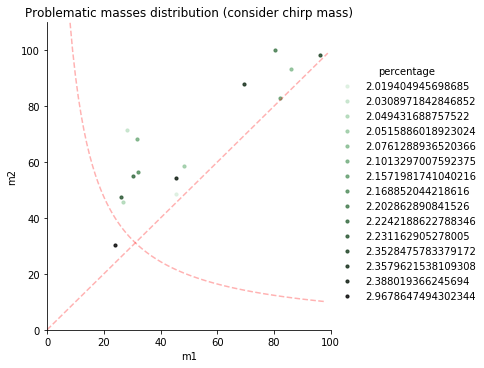

In [27]:
# Summary for training data 1B:

sns.lmplot(x="m1", y="m2",
           hue="percentage",
           data = summary,
           fit_reg=False,
           scatter_kws={"marker": "D",
                        "s": 10},
           palette = sns.cubehelix_palette(len(colors), start=2, rot=0, dark=0, light=.9))

plt.plot(np.arange(100),'r--',alpha=0.3)
plt.plot(1000/np.arange(1,100),'r--',alpha=0.3)

plt.title('Problematic masses distribution (consider chirp mass)')
plt.xlabel('m1')
plt.ylabel('m2')
plt.ylim(0,110)
plt.xlim(0,100)
plt.show()